In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import PIL

#from utils import *
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print (device)

cuda:0


## Data preprocessing

### Reading data

In [3]:
def shuffle_data(X, y):
    r = np.random.permutation(len(y))
    return X[r], y[r]

In [4]:
data = np.genfromtxt('./train.csv', delimiter=',')
data = np.delete(data, (0), axis=0)
data_np_y = data[:,0]
data = np.delete(data, (0), axis=1)
data_np_x = data / 255

data_np_x, data_np_y = shuffle_data(data_np_x, data_np_y)

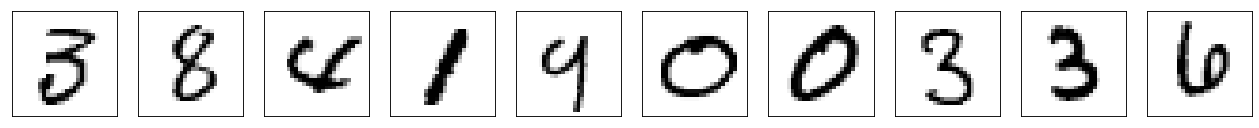

[3. 8. 4. 1. 9. 0. 0. 3. 3. 6.]


In [5]:
fig = plt.figure(figsize=(20,10), dpi=80)
shape = (1,10)
for j in range(10):
    ax = fig.add_subplot(shape[0], shape[1], j+1)
    image = data_np_x[j].reshape(28,28)
    ax.matshow(image, cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()

print (data_np_y[:10])

### Data augmentation

In [6]:
noise_factor = 0.1
# Add random noise to the input images
data_noisy_x1 = data_np_x + noise_factor * np.random.randn(*data_np_x.shape)
# Clip the images to be between 0 and 1
data_noisy_x1 = np.clip(data_noisy_x1, 0., 1.)

data_noisy_y1 = data_np_y

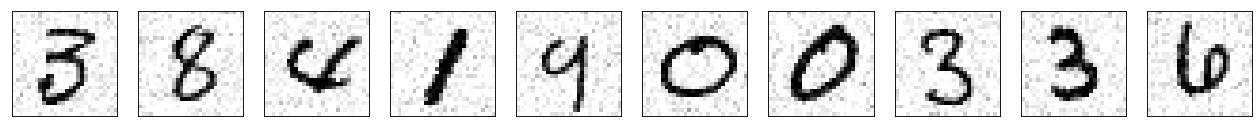

[3. 8. 4. 1. 9. 0. 0. 3. 3. 6.]


In [7]:
fig = plt.figure(figsize=(20,10), dpi=80)
shape = (1,10)
for j in range(10):
    ax = fig.add_subplot(shape[0], shape[1], j+1)
    image = data_noisy_x1[j].reshape(28,28)
    ax.matshow(image, cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()

print (data_noisy_y1[:10])

In [8]:
noise_factor = 0.2
# Add random noise to the input images
data_noisy_x2 = data_np_x + noise_factor * np.random.randn(*data_np_x.shape)
# Clip the images to be between 0 and 1
data_noisy_x2 = np.clip(data_noisy_x2, 0., 1.)

data_noisy_y2 = data_np_y

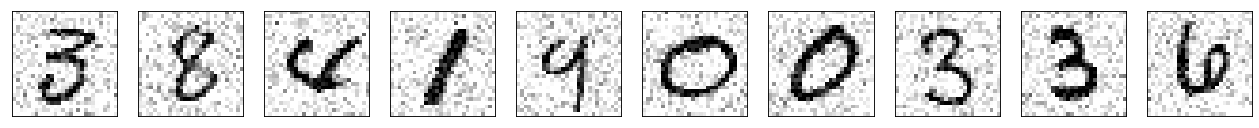

[3. 8. 4. 1. 9. 0. 0. 3. 3. 6.]


In [9]:
fig = plt.figure(figsize=(20,10), dpi=80)
shape = (1,10)
for j in range(10):
    ax = fig.add_subplot(shape[0], shape[1], j+1)
    image = data_noisy_x2[j].reshape(28,28)
    ax.matshow(image, cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()

print (data_noisy_y2[:10])

In [10]:
noise_factor = 0.3
# Add random noise to the input images
data_noisy_x3 = data_np_x + noise_factor * np.random.randn(*data_np_x.shape)
# Clip the images to be between 0 and 1
data_noisy_x3 = np.clip(data_noisy_x3, 0., 1.)

data_noisy_y3 = data_np_y

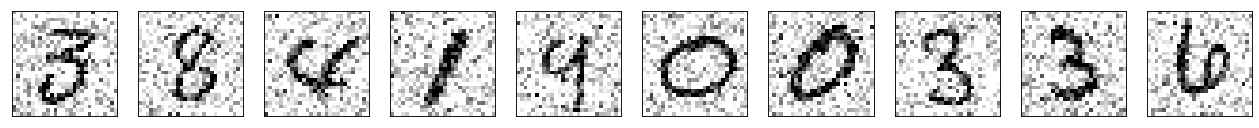

[3. 8. 4. 1. 9. 0. 0. 3. 3. 6.]


In [11]:
fig = plt.figure(figsize=(20,10), dpi=80)
shape = (1,10)
for j in range(10):
    ax = fig.add_subplot(shape[0], shape[1], j+1)
    image = data_noisy_x3[j].reshape(28,28)
    ax.matshow(image, cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()

print (data_noisy_y1[:10])

### Making final dataset

In [12]:
data_x = np.vstack((data_np_x, data_noisy_x1, data_noisy_x2, data_noisy_x3))
data_y = np.hstack((data_np_y, data_noisy_y1, data_noisy_y2, data_noisy_y3))

data_x, data_y = shuffle_data(data_x, data_y)
#print (data_np_x.shape, data_noisy_x.shape)
print (data_x.shape, data_y.shape)

(168000, 784) (168000,)


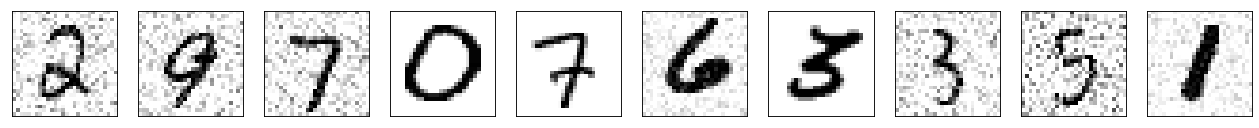

[2. 9. 7. 0. 7. 6. 3. 3. 5. 1.]


In [13]:
fig = plt.figure(figsize=(20,10), dpi=80)
shape = (1,10)
for j in range(10):
    ax = fig.add_subplot(shape[0], shape[1], j+1)
    image = data_x[j].reshape(28,28)
    ax.matshow(image, cmap=matplotlib.cm.binary)
    plt.xticks(np.array([]))
    plt.yticks(np.array([]))
plt.show()

print (data_y[:10])

In [14]:
pos = int(data_x.shape[0] * 0.9)

train_np_y = data_y[:pos]
train_np_x = data_x[:pos]
test_np_y = data_y[pos:]
test_np_x = data_x[pos:]

In [15]:
print (data_x.shape, data_y.shape)
print (train_np_x.shape, train_np_y.shape)
print (test_np_x.shape, test_np_y.shape)

(168000, 784) (168000,)
(151200, 784) (151200,)
(16800, 784) (16800,)


In [16]:
def normalize(x):
    x = (x - 0.1307) / 0.3081    
    return x

In [17]:
train_x = torch.Tensor(np.expand_dims(normalize(train_np_x), axis=1)).to(device)
train_y = torch.LongTensor(train_np_y).to(device)

test_x = torch.Tensor(np.expand_dims(normalize(test_np_x), axis=1)).to(device)
test_y = torch.LongTensor(test_np_y).to(device)

## Neural network

In [18]:
def loader(x, y, batch_size=64):
    for i in range(0, x.size(0) - 1, batch_size):
        data = x[i:i+batch_size]        
        if data.shape[0] == batch_size:
            data = data.reshape(batch_size, 1, 28, 28)
            targets = y[i:i+batch_size]

            yield data, targets
    

In [19]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU(), stride=1):
        super(ConvLayer, self).__init__()
        layers = []        
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers).to(device)
    
    def forward(self, x):
        return self.model(x)

In [20]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))            
        
        self.model = nn.Sequential(*layers).to(device)
        
    def forward(self, x):
        return self.model(x)


In [21]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, lr=5e-5, l2=.0):
        super(Net, self).__init__()
        
        
        #self._conv1 = ConvLayer([1, 16, 3], bn=batchnorm)   
        #self._conv2 = ConvLayer([16, 32, 3], bn=batchnorm) 
        #self._conv3 = ConvLayer([32, 64, 3], bn=batchnorm, activation_fn=nn.Sigmoid())
    
        self._conv1 = ConvLayer([1, 32, 3], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv2 = ConvLayer([32, 64, 3], padding=0, bn=batchnorm, stride=2, 
                                pool_layer=None, activation_fn=nn.Tanh())
        self._conv3 = ConvLayer([64, 128, 3], padding=0, bn=batchnorm, stride=2, 
                                pool_layer=None, activation_fn=nn.Sigmoid())
        
        self.fc = FullyConnected([128*2*2, 256, 10], dropout=dropout)
        
        self.lr = lr
        self.lr_base = lr
        self.l2 = l2
        self._loss = None
        self.optim = optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.l2)
    
    def conv(self, x):        
        x = self._conv1(x)
        x = self._conv2(x)
        x = self._conv3(x)    
        return x
        
    def forward(self, x):        
        x = self.conv(x)
        x = x.view(-1, 128*2*2) # 64*7*7
        x = self.fc(x)        
        return x
    
    def loss(self, output, target, **kwargs):         
        self._loss = F.cross_entropy(output, target, **kwargs)
        self._correct = output.data.max(1, keepdim=True)[1]
        self._correct = self._correct.eq(target.data.view_as(self._correct)).to(torch.float).cpu().mean()
        return self._loss

In [22]:
def train(epoch, models, log=None):    
    for model in models.values():
        model.lr = model.lr_base * (50 / (epoch + 50))        
        model.optim = optim.Adam(model.parameters(), lr=model.lr, weight_decay=model.l2)
    print ("LR: {}".format(models['plain'].lr))    
    train_size = len(train_x)
       
    
    for batch_idx, (data, target) in enumerate(loader(train_x, train_y, batch_size=32)):        
        for model in models.values():                             
            model.optim.zero_grad()
            output = model(data)
            loss = model.loss(output, target)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 1000 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / train_size)
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / train_size)
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss, models[k]._correct))
        print(line + losses)

In [23]:
def test(models, log=None):
    test_size = len(test_x)
    avg_lambda = lambda l: 'Loss: {:.4f}'.format(l)
    acc_lambda = lambda c, p: 'Accuracy: {}/{} ({:.0f}%)'.format(c, test_size, p)
    line = lambda i, l, c, p: '{}: '.format(i) + avg_lambda(l) + '\t' + acc_lambda(c, p)

    test_loss = {k: 0. for k in models}
    correct = {k: 0. for k in models}
    with torch.no_grad():
        for data, target in loader(test_x, test_y, batch_size=32):
            output = {k: m(data) for k, m in models.items()}           
            for k, m in models.items():     
                #print (output[k].shape, target.shape)
                test_loss[k] += m.loss(output[k], target, size_average=False).item() # sum up batch loss
                pred = output[k].data.max(1, keepdim=True)[1] # get the index of the max log-probability
                correct[k] += pred.eq(target.data.view_as(pred)).cpu().sum().item()
    
    for k in models:
        test_loss[k] /= test_size
    correct_pct = {k: c / test_size for k, c in correct.items()}
    lines = '\n'.join([line(k, test_loss[k], correct[k], 100*correct_pct[k]) for k in models]) + '\n'
    report = 'Test set:\n' + lines
    if log is not None:
        for k in models:
            log[k].append((test_loss[k], correct_pct[k]))
    print(report)

In [24]:
def plot_graphs(log, tpe='loss'):
    keys = log.keys()
    logs = {k:[z for z in zip(*log[k])] for k in keys}
    epochs = {k:range(len(log[k])) for k in keys}
 
    
    if tpe == 'loss':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][0], label=k) for k in keys])
        plt.title('errors')
        plt.xlabel('epoch')
        plt.ylabel('error')
        plt.legend(handles=handlers)
        plt.show()
    elif tpe == 'accuracy':
        handlers, = zip(*[plt.plot(epochs[k], logs[k][1], label=k) for k in log.keys()])
        plt.title('accuracy')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.legend(handles=handlers)
        plt.show()

In [25]:
models = {'plain': Net(), 'drop': Net(False, True)}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [26]:
print (models['plain'])

Net(
  (_conv1): ConvLayer(
    (model): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU()
    )
  )
  (_conv2): ConvLayer(
    (model): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): Tanh()
    )
  )
  (_conv3): ConvLayer(
    (model): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
      (1): Sigmoid()
    )
  )
  (fc): FullyConnected(
    (model): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): Tanh()
      (2): Linear(in_features=256, out_features=10, bias=True)
    )
  )
)


In [27]:
for epoch in range(1, 101):
    for model in models.values():
        model.train()
    train_x, train_y = shuffle_data(train_x, train_y)    
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, test_log)

LR: 4.901960784313725e-05
Train Epoch: 1 [0/151200 (0%)]	Losses plain: 2.302020 bn: 2.318542 drop: 2.318983 bndrop: 2.318598
Train Epoch: 1 [32000/151200 (1%)]	Losses plain: 0.909232 bn: 0.706512 drop: 0.947389 bndrop: 0.874166
Train Epoch: 1 [64000/151200 (1%)]	Losses plain: 0.154030 bn: 0.134359 drop: 0.239296 bndrop: 0.218717
Train Epoch: 1 [96000/151200 (2%)]	Losses plain: 0.369612 bn: 0.183439 drop: 0.485144 bndrop: 0.246574
Train Epoch: 1 [128000/151200 (3%)]	Losses plain: 0.375090 bn: 0.096518 drop: 0.424092 bndrop: 0.217593
Train Epoch: 1 [151200/151200 (3%)]	Losses plain: 0.147141 bn: 0.139051 drop: 0.209878 bndrop: 0.174543


/home/aleksey/.conda/envs/kaggle/lib/python3.6/site-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Test set:
plain: Loss: 0.2448	Accuracy: 15609.0/16800 (93%)
bn: Loss: 0.1449	Accuracy: 16107.0/16800 (96%)
drop: Loss: 0.2480	Accuracy: 15539.0/16800 (92%)
bndrop: Loss: 0.1356	Accuracy: 16123.0/16800 (96%)

LR: 4.8076923076923084e-05
Train Epoch: 2 [0/151200 (0%)]	Losses plain: 0.274778 bn: 0.164500 drop: 0.270907 bndrop: 0.127860
Train Epoch: 2 [32000/151200 (1%)]	Losses plain: 0.322546 bn: 0.134395 drop: 0.285109 bndrop: 0.199320
Train Epoch: 2 [64000/151200 (1%)]	Losses plain: 0.110183 bn: 0.128046 drop: 0.168408 bndrop: 0.164488
Train Epoch: 2 [96000/151200 (2%)]	Losses plain: 0.121282 bn: 0.028170 drop: 0.143478 bndrop: 0.043754
Train Epoch: 2 [128000/151200 (3%)]	Losses plain: 0.052123 bn: 0.072035 drop: 0.079229 bndrop: 0.055923
Train Epoch: 2 [151200/151200 (3%)]	Losses plain: 0.086124 bn: 0.042268 drop: 0.114203 bndrop: 0.070097
Test set:
plain: Loss: 0.1582	Accuracy: 16005.0/16800 (95%)
bn: Loss: 0.0952	Accuracy: 16312.0/16800 (97%)
drop: Loss: 0.1587	Accuracy: 16003.0/16800

Train Epoch: 11 [96000/151200 (2%)]	Losses plain: 0.022851 bn: 0.098157 drop: 0.028444 bndrop: 0.070141
Train Epoch: 11 [128000/151200 (3%)]	Losses plain: 0.002463 bn: 0.000262 drop: 0.001631 bndrop: 0.002752
Train Epoch: 11 [151200/151200 (3%)]	Losses plain: 0.010049 bn: 0.016192 drop: 0.034298 bndrop: 0.051176
Test set:
plain: Loss: 0.0346	Accuracy: 16628.0/16800 (99%)
bn: Loss: 0.0303	Accuracy: 16624.0/16800 (99%)
drop: Loss: 0.0382	Accuracy: 16604.0/16800 (99%)
bndrop: Loss: 0.0439	Accuracy: 16577.0/16800 (99%)

LR: 4.032258064516129e-05
Train Epoch: 12 [0/151200 (0%)]	Losses plain: 0.011574 bn: 0.021355 drop: 0.039629 bndrop: 0.018271
Train Epoch: 12 [32000/151200 (1%)]	Losses plain: 0.010385 bn: 0.002202 drop: 0.010585 bndrop: 0.005520
Train Epoch: 12 [64000/151200 (1%)]	Losses plain: 0.002303 bn: 0.002638 drop: 0.015906 bndrop: 0.002578
Train Epoch: 12 [96000/151200 (2%)]	Losses plain: 0.008496 bn: 0.002186 drop: 0.009700 bndrop: 0.002710
Train Epoch: 12 [128000/151200 (3%)]	Los

Train Epoch: 21 [32000/151200 (1%)]	Losses plain: 0.000785 bn: 0.000223 drop: 0.002106 bndrop: 0.001241
Train Epoch: 21 [64000/151200 (1%)]	Losses plain: 0.000272 bn: 0.000314 drop: 0.000395 bndrop: 0.000427
Train Epoch: 21 [96000/151200 (2%)]	Losses plain: 0.000838 bn: 0.000020 drop: 0.000707 bndrop: 0.000099
Train Epoch: 21 [128000/151200 (3%)]	Losses plain: 0.003145 bn: 0.020749 drop: 0.005103 bndrop: 0.004964
Train Epoch: 21 [151200/151200 (3%)]	Losses plain: 0.001315 bn: 0.000410 drop: 0.005579 bndrop: 0.002668
Test set:
plain: Loss: 0.0138	Accuracy: 16732.0/16800 (100%)
bn: Loss: 0.0243	Accuracy: 16685.0/16800 (99%)
drop: Loss: 0.0171	Accuracy: 16723.0/16800 (100%)
bndrop: Loss: 0.0281	Accuracy: 16670.0/16800 (99%)

LR: 3.472222222222222e-05
Train Epoch: 22 [0/151200 (0%)]	Losses plain: 0.001822 bn: 0.002591 drop: 0.012066 bndrop: 0.001566
Train Epoch: 22 [32000/151200 (1%)]	Losses plain: 0.004711 bn: 0.013809 drop: 0.016274 bndrop: 0.008808
Train Epoch: 22 [64000/151200 (1%)]	Lo

Test set:
plain: Loss: 0.0105	Accuracy: 16745.0/16800 (100%)
bn: Loss: 0.0275	Accuracy: 16667.0/16800 (99%)
drop: Loss: 0.0146	Accuracy: 16725.0/16800 (100%)
bndrop: Loss: 0.0263	Accuracy: 16670.0/16800 (99%)

LR: 3.08641975308642e-05
Train Epoch: 31 [0/151200 (0%)]	Losses plain: 0.000054 bn: 0.002922 drop: 0.000621 bndrop: 0.001134
Train Epoch: 31 [32000/151200 (1%)]	Losses plain: 0.000782 bn: 0.000160 drop: 0.001980 bndrop: 0.001087
Train Epoch: 31 [64000/151200 (1%)]	Losses plain: 0.000344 bn: 0.000441 drop: 0.002476 bndrop: 0.008756
Train Epoch: 31 [96000/151200 (2%)]	Losses plain: 0.000003 bn: 0.000006 drop: 0.000047 bndrop: 0.000038
Train Epoch: 31 [128000/151200 (3%)]	Losses plain: 0.000152 bn: 0.005021 drop: 0.000342 bndrop: 0.003172
Train Epoch: 31 [151200/151200 (3%)]	Losses plain: 0.000181 bn: 0.000241 drop: 0.000521 bndrop: 0.000567
Test set:
plain: Loss: 0.0108	Accuracy: 16748.0/16800 (100%)
bn: Loss: 0.0223	Accuracy: 16698.0/16800 (99%)
drop: Loss: 0.0145	Accuracy: 16737.

Train Epoch: 40 [96000/151200 (2%)]	Losses plain: 0.000024 bn: 0.000814 drop: 0.001590 bndrop: 0.000208
Train Epoch: 40 [128000/151200 (3%)]	Losses plain: 0.000179 bn: 0.000246 drop: 0.003049 bndrop: 0.002864
Train Epoch: 40 [151200/151200 (3%)]	Losses plain: 0.000095 bn: 0.000048 drop: 0.000179 bndrop: 0.000785
Test set:
plain: Loss: 0.0111	Accuracy: 16756.0/16800 (100%)
bn: Loss: 0.0239	Accuracy: 16701.0/16800 (99%)
drop: Loss: 0.0124	Accuracy: 16740.0/16800 (100%)
bndrop: Loss: 0.0279	Accuracy: 16681.0/16800 (99%)

LR: 2.7472527472527476e-05
Train Epoch: 41 [0/151200 (0%)]	Losses plain: 0.000005 bn: 0.000132 drop: 0.000015 bndrop: 0.000065
Train Epoch: 41 [32000/151200 (1%)]	Losses plain: 0.000039 bn: 0.000134 drop: 0.000092 bndrop: 0.000052
Train Epoch: 41 [64000/151200 (1%)]	Losses plain: 0.000001 bn: 0.000031 drop: 0.000019 bndrop: 0.000016
Train Epoch: 41 [96000/151200 (2%)]	Losses plain: 0.000116 bn: 0.000036 drop: 0.004295 bndrop: 0.000993
Train Epoch: 41 [128000/151200 (3%)]	

Train Epoch: 50 [32000/151200 (1%)]	Losses plain: 0.000047 bn: 0.000025 drop: 0.003272 bndrop: 0.000819
Train Epoch: 50 [64000/151200 (1%)]	Losses plain: 0.000001 bn: 0.000003 drop: 0.000005 bndrop: 0.000102
Train Epoch: 50 [96000/151200 (2%)]	Losses plain: 0.000015 bn: 0.000305 drop: 0.000205 bndrop: 0.000212
Train Epoch: 50 [128000/151200 (3%)]	Losses plain: 0.000007 bn: 0.000009 drop: 0.000161 bndrop: 0.000102
Train Epoch: 50 [151200/151200 (3%)]	Losses plain: 0.000000 bn: 0.000007 drop: 0.000009 bndrop: 0.000033
Test set:
plain: Loss: 0.0118	Accuracy: 16761.0/16800 (100%)
bn: Loss: 0.0261	Accuracy: 16695.0/16800 (99%)
drop: Loss: 0.0131	Accuracy: 16745.0/16800 (100%)
bndrop: Loss: 0.0274	Accuracy: 16687.0/16800 (99%)

LR: 2.4752475247524754e-05
Train Epoch: 51 [0/151200 (0%)]	Losses plain: 0.000002 bn: 0.000048 drop: 0.000326 bndrop: 0.000050
Train Epoch: 51 [32000/151200 (1%)]	Losses plain: 0.000000 bn: 0.000020 drop: 0.000006 bndrop: 0.000041
Train Epoch: 51 [64000/151200 (1%)]	L

Test set:
plain: Loss: 0.0117	Accuracy: 16767.0/16800 (100%)
bn: Loss: 0.0248	Accuracy: 16698.0/16800 (99%)
drop: Loss: 0.0145	Accuracy: 16752.0/16800 (100%)
bndrop: Loss: 0.0278	Accuracy: 16689.0/16800 (99%)

LR: 2.272727272727273e-05
Train Epoch: 60 [0/151200 (0%)]	Losses plain: 0.000000 bn: 0.000052 drop: 0.000197 bndrop: 0.000113
Train Epoch: 60 [32000/151200 (1%)]	Losses plain: 0.000004 bn: 0.000004 drop: 0.000051 bndrop: 0.000173
Train Epoch: 60 [64000/151200 (1%)]	Losses plain: 0.000000 bn: 0.000021 drop: 0.000032 bndrop: 0.000034
Train Epoch: 60 [96000/151200 (2%)]	Losses plain: 0.000000 bn: 0.001239 drop: 0.000143 bndrop: 0.000050
Train Epoch: 60 [128000/151200 (3%)]	Losses plain: 0.000000 bn: 0.000001 drop: 0.000006 bndrop: 0.000005
Train Epoch: 60 [151200/151200 (3%)]	Losses plain: 0.000001 bn: 0.000020 drop: 0.000003 bndrop: 0.000323
Test set:
plain: Loss: 0.0120	Accuracy: 16763.0/16800 (100%)
bn: Loss: 0.0225	Accuracy: 16709.0/16800 (99%)
drop: Loss: 0.0131	Accuracy: 16749

Train Epoch: 69 [96000/151200 (2%)]	Losses plain: 0.000000 bn: 0.000283 drop: 0.000011 bndrop: 0.000382
Train Epoch: 69 [128000/151200 (3%)]	Losses plain: 0.000000 bn: 0.000000 drop: 0.000001 bndrop: 0.000001
Train Epoch: 69 [151200/151200 (3%)]	Losses plain: 0.000000 bn: 0.000004 drop: 0.000009 bndrop: 0.000037
Test set:
plain: Loss: 0.0133	Accuracy: 16764.0/16800 (100%)
bn: Loss: 0.0221	Accuracy: 16712.0/16800 (99%)
drop: Loss: 0.0139	Accuracy: 16752.0/16800 (100%)
bndrop: Loss: 0.0249	Accuracy: 16717.0/16800 (100%)

LR: 2.0833333333333336e-05
Train Epoch: 70 [0/151200 (0%)]	Losses plain: 0.000000 bn: 0.000261 drop: 0.000007 bndrop: 0.000089
Train Epoch: 70 [32000/151200 (1%)]	Losses plain: 0.000000 bn: 0.000004 drop: 0.000025 bndrop: 0.000112
Train Epoch: 70 [64000/151200 (1%)]	Losses plain: 0.000000 bn: 0.000006 drop: 0.000030 bndrop: 0.000876
Train Epoch: 70 [96000/151200 (2%)]	Losses plain: 0.000000 bn: 0.000012 drop: 0.000009 bndrop: 0.000133
Train Epoch: 70 [128000/151200 (3%)]

Train Epoch: 79 [32000/151200 (1%)]	Losses plain: 0.000000 bn: 0.000004 drop: 0.000039 bndrop: 0.000355
Train Epoch: 79 [64000/151200 (1%)]	Losses plain: 0.000000 bn: 0.000002 drop: 0.000010 bndrop: 0.000001
Train Epoch: 79 [96000/151200 (2%)]	Losses plain: 0.000000 bn: 0.000007 drop: 0.000020 bndrop: 0.000026
Train Epoch: 79 [128000/151200 (3%)]	Losses plain: 0.000000 bn: 0.000028 drop: 0.000004 bndrop: 0.000080
Train Epoch: 79 [151200/151200 (3%)]	Losses plain: 0.000000 bn: 0.000002 drop: 0.000001 bndrop: 0.000053
Test set:
plain: Loss: 0.0130	Accuracy: 16765.0/16800 (100%)
bn: Loss: 0.0228	Accuracy: 16718.0/16800 (100%)
drop: Loss: 0.0149	Accuracy: 16754.0/16800 (100%)
bndrop: Loss: 0.0284	Accuracy: 16695.0/16800 (99%)

LR: 1.923076923076923e-05
Train Epoch: 80 [0/151200 (0%)]	Losses plain: 0.000000 bn: 0.000000 drop: 0.000360 bndrop: 0.000004
Train Epoch: 80 [32000/151200 (1%)]	Losses plain: 0.000000 bn: 0.000000 drop: 0.000034 bndrop: 0.000008
Train Epoch: 80 [64000/151200 (1%)]	L

Test set:
plain: Loss: 0.0129	Accuracy: 16766.0/16800 (100%)
bn: Loss: 0.0231	Accuracy: 16715.0/16800 (99%)
drop: Loss: 0.0133	Accuracy: 16760.0/16800 (100%)
bndrop: Loss: 0.0273	Accuracy: 16706.0/16800 (99%)

LR: 1.7985611510791367e-05
Train Epoch: 89 [0/151200 (0%)]	Losses plain: 0.000000 bn: 0.000000 drop: 0.000001 bndrop: 0.000002
Train Epoch: 89 [32000/151200 (1%)]	Losses plain: 0.000000 bn: 0.000005 drop: 0.000196 bndrop: 0.000037
Train Epoch: 89 [64000/151200 (1%)]	Losses plain: 0.000000 bn: 0.000004 drop: 0.000002 bndrop: 0.000021
Train Epoch: 89 [96000/151200 (2%)]	Losses plain: 0.000000 bn: 0.000006 drop: 0.000013 bndrop: 0.000046
Train Epoch: 89 [128000/151200 (3%)]	Losses plain: 0.000000 bn: 0.000015 drop: 0.000030 bndrop: 0.000084
Train Epoch: 89 [151200/151200 (3%)]	Losses plain: 0.000000 bn: 0.000003 drop: 0.000014 bndrop: 0.000063
Test set:
plain: Loss: 0.0129	Accuracy: 16768.0/16800 (100%)
bn: Loss: 0.0226	Accuracy: 16724.0/16800 (100%)
drop: Loss: 0.0138	Accuracy: 167

Train Epoch: 98 [96000/151200 (2%)]	Losses plain: 0.000000 bn: 0.000030 drop: 0.000000 bndrop: 0.000406
Train Epoch: 98 [128000/151200 (3%)]	Losses plain: 0.000000 bn: 0.000000 drop: 0.000001 bndrop: 0.000002
Train Epoch: 98 [151200/151200 (3%)]	Losses plain: 0.000000 bn: 0.000001 drop: 0.000005 bndrop: 0.002901
Test set:
plain: Loss: 0.0123	Accuracy: 16768.0/16800 (100%)
bn: Loss: 0.0239	Accuracy: 16717.0/16800 (100%)
drop: Loss: 0.0142	Accuracy: 16755.0/16800 (100%)
bndrop: Loss: 0.0284	Accuracy: 16709.0/16800 (99%)

LR: 1.6778523489932888e-05
Train Epoch: 99 [0/151200 (0%)]	Losses plain: 0.000000 bn: 0.000000 drop: 0.000000 bndrop: 0.000010
Train Epoch: 99 [32000/151200 (1%)]	Losses plain: 0.000000 bn: 0.000000 drop: 0.000001 bndrop: 0.000006
Train Epoch: 99 [64000/151200 (1%)]	Losses plain: 0.000000 bn: 0.000003 drop: 0.000002 bndrop: 0.000091
Train Epoch: 99 [96000/151200 (2%)]	Losses plain: 0.000000 bn: 0.000000 drop: 0.000005 bndrop: 0.000021
Train Epoch: 99 [128000/151200 (3%)]

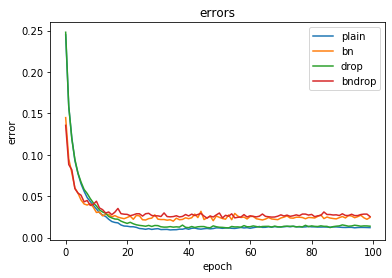

In [28]:
plot_graphs(test_log, 'loss')

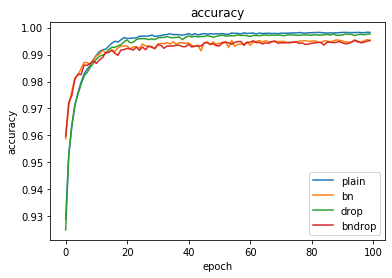

In [29]:
plot_graphs(test_log, 'accuracy')

## Submission

In [46]:
data = np.genfromtxt('./test.csv', delimiter=',')
data = np.delete(data, (0), axis=0)
data_np_x = data / 255

testing_x = torch.Tensor(np.expand_dims(normalize(data_np_x), axis=1)).to(device)
testing_y = torch.LongTensor(np.zeros((testing_x.shape[0], 1))).to(device)

In [47]:
print (testing_x.shape)

torch.Size([28000, 1, 784])


In [48]:
answers = np.empty((0, 10))
model = models['drop']
print (model)

for batch_idx, (data, target) in enumerate(loader(testing_x, testing_y, batch_size=32)):
    output = model(data)  
    output_np = output.cpu().detach().numpy()        
    answers = np.vstack((answers, output_np))
        
print (answers.shape)

Net(
  (_conv1): ConvLayer(
    (model): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU()
    )
  )
  (_conv2): ConvLayer(
    (model): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
      (1): Tanh()
    )
  )
  (_conv3): ConvLayer(
    (model): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2))
      (1): Sigmoid()
    )
  )
  (fc): FullyConnected(
    (model): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): Dropout(p=0.5, inplace=False)
      (2): Tanh()
      (3): Linear(in_features=256, out_features=10, bias=True)
    )
  )
)
(28000, 10)


In [49]:
vals = np.argmax(answers, axis=1)

In [50]:
print (answers[:100])

[[ 6.48076200e+00 -1.02105665e+01  4.95207481e+01  4.34988499e-01
  -6.05412436e+00 -2.91063766e+01 -9.57434082e+00 -3.75561619e+00
   1.22147667e+00 -1.61410294e+01]
 [ 4.51599007e+01 -1.69489822e+01  7.08961535e+00 -9.97525597e+00
  -1.58094616e+01  2.27498472e-01  2.76433118e-03  2.11559296e+00
  -5.43799400e+00 -1.75082695e+00]
 [-8.61707783e+00 -2.02724018e+01 -1.29231405e+01 -7.18601942e+00
   5.20786238e+00 -3.94436598e+00 -2.37884274e+01 -5.77836573e-01
   5.42041111e+00  3.62337379e+01]
 [ 1.34191990e+01 -2.81796646e+01 -4.53407383e+00 -4.93816710e+00
  -6.31055307e+00 -4.07882556e-02 -1.18181934e+01 -4.38597965e+00
  -1.12574303e+00  2.96268253e+01]
 [-1.22312889e+01 -5.84344292e+00  1.52025402e+00  4.63527946e+01
  -2.97966061e+01  2.01286745e+00 -2.73900661e+01 -2.72188878e+00
   2.45957470e+00 -7.59334564e-01]
 [-1.30671635e+01 -1.14059582e+01 -1.48081636e+01  1.09720945e+01
  -1.11151218e+01  5.66314340e-01 -2.95649395e+01  2.25498047e+01
  -4.67136955e+00  1.85965786e+01

In [51]:
print (vals[:1000])

[2 0 9 9 3 7 0 3 0 3 5 7 4 0 4 3 3 1 9 0 9 1 1 5 7 4 2 7 4 7 7 5 4 2 6 2 5
 5 1 6 7 7 4 9 8 7 8 2 6 7 6 8 8 3 8 2 1 2 2 5 4 1 7 0 0 0 1 9 0 1 6 5 8 8
 2 8 9 9 2 3 5 4 1 0 9 2 4 3 6 7 2 0 6 6 1 4 3 9 7 4 0 9 2 0 7 3 0 5 0 8 0
 0 4 7 1 7 1 1 3 3 3 7 2 8 6 3 8 7 8 4 3 5 6 0 0 0 3 1 3 6 4 3 4 5 5 8 7 7
 2 8 4 3 5 6 5 3 7 5 7 8 3 0 4 5 1 2 7 6 3 0 2 7 8 6 1 3 7 4 1 2 4 8 5 2 4
 9 2 1 6 0 6 1 4 9 6 0 9 7 6 9 1 9 0 9 9 0 8 4 6 2 0 9 3 6 3 2 1 6 3 4 2 3
 1 2 2 0 4 6 1 0 0 4 9 1 7 3 2 3 8 6 8 6 2 8 5 5 4 8 3 5 9 7 1 3 8 4 5 1 4
 5 6 3 3 5 7 0 6 8 3 1 6 0 6 3 9 3 1 5 8 4 0 9 2 0 5 3 7 1 9 9 5 7 7 9 9 6
 3 0 3 3 6 9 8 2 6 3 7 1 4 5 8 5 9 0 0 3 8 4 1 8 4 1 1 9 8 4 5 1 5 3 6 3 1
 3 0 9 0 0 6 0 6 3 1 8 6 0 6 5 2 2 6 7 7 2 5 8 3 9 2 7 8 6 3 8 4 2 3 8 1 6
 4 8 7 9 7 6 9 5 3 7 6 5 5 4 2 6 2 1 3 7 1 7 9 9 6 1 1 1 7 3 9 7 6 1 1 1 9
 3 8 5 5 0 4 1 2 3 1 1 3 5 9 6 6 5 3 1 4 7 4 7 4 8 5 2 6 1 3 9 5 0 8 4 7 4
 4 4 1 5 3 9 5 7 6 9 5 9 2 3 5 6 6 7 5 0 5 1 7 4 4 1 1 4 9 5 6 0 1 3 1 0 4
 8 1 2 7 9 4 8 3 7 7 4 2 

In [52]:
print (vals.shape)

(28000,)


In [53]:
with open("submission4.txt", "w") as fout:
    fout.write("ImageId,Label\n")
    for i, val in enumerate(vals):
        fout.write("{},{}\n".format(str(i+1), str(val)))
        